# Analysis of collision data

This notebook will expose the analysis of two-body cell collisions, and it highlights how each figure in the main text are produced.

### Figure 1
- This is directly the output of the simulation, a view of the simulation box.
- The figure in the text consists of 3 distinct simulations, and it is further annotated for clarity

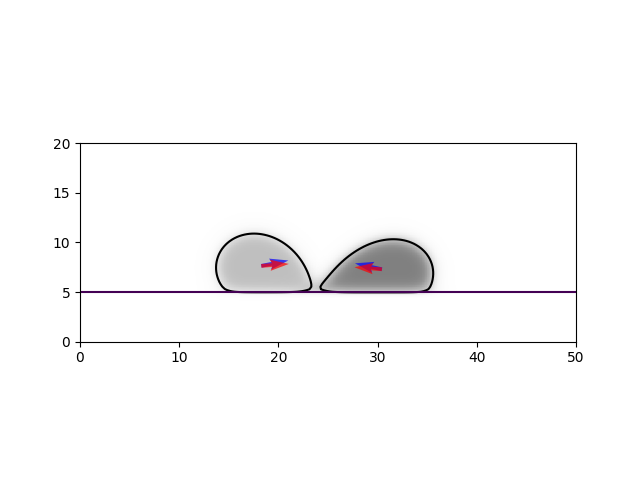

In [1]:
import os
from glob import glob
from IPython.display import Image

sim_view_path = os.path.join(
    os.path.dirname(os.path.abspath("")), "output/grid_id27/run_0/visuals/*"
)
sim_views = glob(sim_view_path)
Image(sim_views[0], retina=True)


### Figure 3
- Aggregate the winning fraction, difference in CM speeds, and difference in contact angles between the two cells across 96 simulations run per each input feature of (tension `gamma`, adhesion `A`, strength of protrusion `beta`)
- The left cell remains constant with default values of `gamma = 1.26`, `A = 0.48`, and `beta = 6`.

Some helper functions

In [2]:
import pandas as pd
import numpy as np
from glob import glob
from multiprocessing import Pool


def outcomes_df(files):
    """
    Reads collision results in parallel and stores them in a dataframe.

    Parameters
    ----------
    files : list of str
        List of all paths to .csv files.

    Returns
    -------
    pd.DataFrame
        Outcome of all collisions.
        Columns are:
        [
            gamma -- tension of varying cell,
            A -- adhesion of varying cell,
            beta -- protrusion strength of varying cell,
            dv -- pre-collision average CM speed difference,
            dtheta -- pre-collision average contact angle difference,
            Pwin -- 0/1 denoting loss or win
        ]
        There are 462 * 96 == 44,352 records
    """
    with Pool(processes=8) as p:
        res = p.map_async(_collision_outcome, files)
        p.close()
        p.join()

    res = res.get(timeout=1)
    table = [
        pd.DataFrame([el], columns=["gamma", "A", "beta", "dv", "dtheta", "Pwin"])
        for el in res
    ]
    return pd.concat(table).reset_index(drop=True)


def two_feature_stats(table, features, const_feat):
    """
    Computes the mean win probability, difference in CM speed,
    and difference in contact angle, averaged over 96 runs for
    the given set of 2D features with the third held fixed.

    Parameters
    ----------
    table : pd.DataFrame
        Outcome of all collisions.
    features : dict
        Keys -- str, denoting features to plot on the x and y axes, respectively
        Vals -- ndarray, denoting the span of each feature.
    const_feat : tuple
        (name of feature to hold constant, value to assign)

    Returns
    -------
    dict
        You get the following out keys:
           - x, y : values of features
           - Pwin, dv, dtheta : averages over the 96 runs 
    """
    # cf: feature to keep constant
    # cv: value of this feature
    cf, cv = const_feat
    df = table[table[cf] == cv]

    # x and y features, in that order
    x_feat, y_feat = features.keys()
    x_feat_vals, y_feat_vals = features.values()

    # group data by the relevant features and aggregate by mean
    df = df.groupby([y_feat, x_feat]).apply("mean")

    # build the observables in this two-feature space
    dv_mat, dtheta_mat, Pwin_mat = [], [], []
    x, y = np.meshgrid(x_feat_vals, y_feat_vals)

    for y_feat_val, df in df.groupby(y_feat):
        dv_mat.append(df.dv.values)
        dtheta_mat.append(df.dtheta.values)
        Pwin_mat.append(df.Pwin.values)

    return {
        "x": x_feat_vals,
        "y": y_feat_vals,
        "Pwin": np.array(Pwin_mat),
        "dv": np.array(dv_mat),
        "dtheta": np.array(dtheta_mat),
    }


def two_feature_plots(table):
    """
    Makes a 3x3 plot showcasing the win probability, diff in CM speed,
    and diff in contact angle as a function of two features with the
    third held fixed.

    Parameters
    ----------
    table : pd.DataFrame
        Outcome of all collisions.
    """
    import matplotlib.pyplot as plt

    plt.style.use("../configs/stylesheet.mplstyle")

    # default feature values
    GAMMA = 1.26
    A = 0.48
    BETA = 6

    # conversion to real units
    V_SCALE = 6 / 8  # mu/min

    # the complete span of feature-space
    betas = np.linspace(4, 10, 6)
    gammas = np.linspace(0.9, 1.8, 7)
    As = np.linspace(0.32, 0.64, 11)

    # two feature states we want to visit
    two_feat_sets = [
        dict([("beta", betas), ("A", As)]),
        dict([("beta", betas), ("gamma", gammas)]),
        dict([("gamma", gammas), ("A", As)]),
    ]

    # feature to hold constant
    const_feat_set = [("gamma", 1.2), ("A", 0.48), ("beta", 6.4)]

    # find bounds
    min_dv, max_dv, min_dtheta, max_dtheta = _bounds(
        table, two_feat_sets, const_feat_set
    )

    # set up figure
    fig = plt.figure(figsize=(15, 12))
    cmap = "PuBu"
    n_levels = 6

    # make 1x3 plots
    for i, (features, const_feat) in enumerate(zip(two_feat_sets, const_feat_set)):
        res = two_feature_stats(table, features, const_feat)
        x, y = res["x"], res["y"]
        zs = [res["Pwin"], res["dv"] * V_SCALE, res["dtheta"]]
        js = np.array([0, 1, 2]) + 3 * i
        ls = [
            np.linspace(0, 1, n_levels),
            np.linspace(min_dv * V_SCALE, max_dv * V_SCALE, n_levels),
            np.linspace(min_dtheta, max_dtheta, n_levels),
        ]
        titles = "ABCDEFGHI"
        z_feats = ["Pwin", "dv", "dtheta"] * 3
        formats = ["%.1f", "%.2f", "%.0f"] * 3

        for j, z, l in zip(js, zs, ls):
            plt.subplot(3, 3, j + 1)
            plt.contourf(x, y, z, levels=l, cmap=cmap, alpha=0.7)
            x_feat, y_feat = features.keys()
            plt.xlabel(_label(x_feat))
            plt.ylabel(_label(y_feat))
            plt.title(f"({titles[j]})", loc="left", x=-0.3)
            cbar = plt.colorbar(format=formats[j])
            cbar.set_label(_label(z_feats[j]))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.5, hspace=0.3)


def _label(feature_name):
    if feature_name == "gamma":
        return "Rel. tension"

    if feature_name == "beta":
        return "Rel. protrusion strength"

    if feature_name == "A":
        return "Rel. adhesion strength"

    if feature_name == "dv":
        return "$\delta v\ [\mathrm{\mu m/min}]$"

    if feature_name == "dtheta":
        return "$\delta \\theta\ [\degree]$"

    if feature_name == "Pwin":
        return "$P_{win}$"


def _bounds(table, two_feat_sets, const_feat_set):
    min_dv, max_dv = 100, -100
    min_dtheta, max_dtheta = 100, -100
    for features, const_feat in zip(two_feat_sets, const_feat_set):
        res = two_feature_stats(table, features, const_feat)

        local_min, local_max = res["dv"].min(), res["dv"].max()
        min_dv = local_min if local_min < min_dv else min_dv
        max_dv = local_max if local_max > max_dv else max_dv

        local_min, local_max = res["dtheta"].min(), res["dtheta"].max()
        min_dtheta = local_min if local_min < min_dtheta else min_dtheta
        max_dtheta = local_max if local_max > max_dtheta else max_dtheta

    return min_dv, max_dv, min_dtheta, max_dtheta


def _collision_outcome(file):
    """
    Summarizes the outcome of one collision from its temporal history.

    Parameters
    ----------
    file : str
        Path to .csv file storing temporal stats for one simulation.

    Returns
    -------
    list
        [
            tension of varying cell,
            adhesion of varying cell,
            protrusion strength of varying cell,
            pre-collision average CM speed difference,
            pre-collision average contact angle difference,
            0/1 denoting loss or win
        ]
    """
    df = pd.read_csv(os.path.join(file, "result.csv"))
    # fixing negative contact angles 
    df["contact angle"] = df["contact angle"].apply(lambda x: 180 + x if x < 0 else x)
    dv, dtheta = np.diff(
        df.groupby("cell id")[["CM speed", "contact angle"]].apply("mean").values,
        axis=0,
    )[0]
    n_left = len(df[df["coll orientation"] == "left"])
    n_records = len(df)
    Pwin = 1 if n_left > n_records / 2 else 0
    return [df.gamma.iloc[-1], df.A.iloc[-1], df.beta.iloc[-1], dv, dtheta, Pwin]


def _all_files():
    file_path = os.path.join(
        os.path.dirname(os.path.abspath("")), "output/grid_id*/run_*"
    )
    files = glob(file_path)
    return files


The core function call

In [3]:
# collision files
files = _all_files()

# collision outcomes
table_full = outcomes_df(files)
display(table_full.head(10))

# 3x3 plots of Pwin, dv, dtheta as two features
# are swept across, with the third held fixed
two_feature_plots(table_full)

OSError: [Errno 22] Invalid argument: '/mnt/c/Users/pedro/OneDrive - Johns Hopkins/Documents/Research/collider/output/grid_id110/run_95/result.csv'